Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import (
    TimeSeriesTransformerConfig,
    TimeSeriesTransformerForPrediction,
    PretrainedConfig,
)
from gluonts.time_feature import (
    get_lags_for_frequency,
    get_seasonality,
    time_features_from_frequency_str,
)
from gluonts.dataset.pandas import PandasDataset
from gluonts.itertools import Map, Cyclic, Cached
from datasets import Dataset, DatasetDict, Features, Value, Sequence
from functools import lru_cache, partial
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
from typing import Iterable

import torch
from gluonts.dataset.loader import as_stacked_batches
from gluonts.transform.sampler import InstanceSampler
from typing import Optional
from accelerate import Accelerator
from torch.optim import AdamW
from evaluate import load
import math
import matplotlib.dates as mdates
from metrics import print_evaluation_metrics

/home/samuell/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samuell/.local/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
2024-02-04 21:02:04.573590: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-04 21:02:04.613671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-

Load dataset and prepare df

In [10]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date"
target_column = "Close"
id_column = "id"

df = pd.read_csv(file_path)

df["id"] = "id"
df[date_column] = pd.to_datetime(df[date_column])
df.set_index(date_column, inplace=True)

unique_dates = df.index.unique()

Train, validation, test split

In [11]:
df_train = df[df.index < unique_dates[-int(len(unique_dates) *0.8)]]
df_validation = df[df.index < unique_dates[-int(len(unique_dates) *0.9)]]
df_test = df

Process fields for dataset

In [4]:
class ProcessStartField:
    ts_id = 0

    def __call__(self, data):
        data["start"] = data["start"].to_timestamp()
        data["feat_static_cat"] = [self.ts_id]
        data["feat_dynamic_real"] = None
        # data["item_id"] = f"T{self.ts_id+1}"
        self.ts_id += 1
        print(data)
        return data

Features for dataset

In [5]:
features = Features(
    {
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
        "item_id": Value("string"),
    }
)

In [17]:
ds_train = PandasDataset(
    df_train, target=target_column, feat_dynamic_real=['Closed_1_ago']
)
ds_train.__dict__

{'target': 'Close',
 'feat_dynamic_real': ['Closed_1_ago'],
 'past_feat_dynamic_real': None,
 'timestamp': None,
 'freq': 'D',
 'future_length': 0,
 'unchecked': False,
 'assume_sorted': False,
 'dtype': numpy.float32,
 '_data_entries': StarMap(fn=<bound method PandasDataset._pair_to_dataentry of PandasDataset<size=1, freq=D, num_feat_dynamic_real=1, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>>, iterable=[(None,                  Close  Closed_1_ago  Closed_2_ago  Closed_3_ago  \
 Date                                                               
 2014-09-24  423.204987    435.790985    402.152008    398.821014   
 2014-09-25  411.574005    423.204987    435.790985    402.152008   
 2014-09-26  404.424988    411.574005    423.204987    435.790985   
 2014-09-27  399.519989    404.424988    411.574005    423.204987   
 2014-09-28  377.181000    399.519989    404.424988    411.574005   
 ...                ...           ...       

In [16]:
ds_validation = PandasDataset.from_long_dataframe(
    df_validation, target=target_column, item_id=id_column
)
ds_validation.__dict__

{'target': 'Close',
 'feat_dynamic_real': None,
 'past_feat_dynamic_real': None,
 'timestamp': None,
 'freq': 'D',
 'future_length': 0,
 'unchecked': False,
 'assume_sorted': False,
 'dtype': numpy.float32,
 '_data_entries': StarMap(fn=<bound method PandasDataset._pair_to_dataentry of PandasDataset<size=1, freq=D, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>>, iterable=Map(fn=<function pair_with_item_id at 0x7f5d32131f30>, iterable=[('id',                  Close  Closed_1_ago  Closed_2_ago  Closed_3_ago  \
 Date                                                               
 2014-09-24  423.204987    435.790985    402.152008    398.821014   
 2014-09-25  411.574005    423.204987    435.790985    402.152008   
 2014-09-26  404.424988    411.574005    423.204987    435.790985   
 2014-09-27  399.519989    404.424988    411.574005    423.204987   
 2014-09-28  377.181000    399.519989    404.424988    411.57

Create datasets from data frames

In [12]:
ds_train = PandasDataset(
    df_train, target=target_column, feat_dynamic_real=['Closed_1_ago']
)
ds_validation = PandasDataset.from_long_dataframe(
    df_validation, target=target_column, item_id=id_column
)
ds_test = PandasDataset.from_long_dataframe(
    df_test, target=target_column, item_id=id_column
)

process_start = ProcessStartField()
process_start.ts_id = 0
list_ds_train = list(Map(process_start, ds_train))
process_start.ts_id = 0
list_ds_validation = list(Map(process_start, ds_validation))
process_start.ts_id = 0
list_ds_test = list(Map(process_start, ds_test))

train_dataset = Dataset.from_list(list_ds_train, features=features)
validation_dataset = Dataset.from_list(list_ds_validation, features=features)
test_dataset = Dataset.from_list(list_ds_test, features=features)

dataset = DatasetDict(
    {"train": train_dataset, "validation": validation_dataset, "test": test_dataset}
)

{'start': Timestamp('2014-09-24 00:00:00'), 'target': array([423.204987, 411.574005, 404.424988, 399.519989, 377.181   ,
       375.46701 , 386.944   , 383.61499 , 375.071991, 359.511993,
       328.865997, 320.51001 , 330.07901 , 336.187012, 352.940002,
       365.026001, 361.562012, 362.299011, 378.549011, 390.414001,
       400.869995, 394.77301 , 382.556   , 383.757996, 391.441986,
       389.54599 , 382.845001, 386.475006, 383.15799 , 358.416992,
       358.345001, 347.270996, 354.70401 , 352.989014, 357.618011,
       335.591003, 345.304993, 338.321014, 325.748993, 325.891998,
       327.553986, 330.492004, 339.485992, 349.290009, 342.415009,
       345.488007, 363.264008, 366.924011, 367.695007, 423.561005,
       420.734985, 397.817993, 376.132996, 387.881989, 387.40799 ,
       375.197998, 380.554993, 357.839996, 350.847992, 352.920013,
       367.572998, 376.901001, 375.347992, 368.369995, 369.670013,
       376.446991, 375.490997, 378.046997, 379.244995, 381.315002,
       3

ValueError: Keys mismatch: between {'start': Value(dtype='timestamp[s]', id=None), 'target': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'feat_static_cat': Sequence(feature=Value(dtype='uint64', id=None), length=-1, id=None), 'feat_dynamic_real': Sequence(feature=Sequence(feature=Value(dtype='uint64', id=None), length=-1, id=None), length=-1, id=None), 'item_id': Value(dtype='string', id=None)} (source) and {'start': Value(dtype='timestamp[s]', id=None), 'target': Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), 'feat_dynamic_real': Sequence(feature=Sequence(feature=Value(dtype='uint64', id=None), length=-1, id=None), length=-1, id=None), 'feat_static_cat': Sequence(feature=Value(dtype='uint64', id=None), length=-1, id=None)} (target).
{'item_id'} are missing from target and set() are missing from source
The 'source' features come from dataset_info.json, and the 'target' ones are those of the dataset arrow file.

In [8]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [9]:
freq = "D"
prediction_length = int(len(unique_dates) *0.1)


@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [10]:
train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [11]:
lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]


In [12]:
time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function day_of_week at 0x7f149c197910>, <function day_of_month at 0x7f149c197a30>, <function day_of_year at 0x7f149c197b50>]


In [13]:
config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    # we'll add 2 time features ("month of year" and "age"):
    num_time_features=len(time_features) + 1,
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    cardinality=[len(train_dataset)],
    # the model will learn an embedding of size 2 for each one of the possible values:
    embedding_dimension=[2],
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [14]:
def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    """
    Create a transformation pipeline for time series data based on the provided configuration.

    This function constructs a series of data transformations to preprocess time series data
    for a forecasting model. The transformations include removing unused fields, converting data
    to NumPy arrays, handling missing values, adding time-related features, and renaming fields
    to match expected input formats.

    Parameters:
    - freq (str): The frequency of the time series data (e.g., 'M' for monthly data).
    - config (PretrainedConfig): A configuration object that specifies the number and type of
      features in the time series data.

    Returns:
    - Transformation: A transformation pipeline that can be applied to time series data.
    """
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [15]:
def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    """
    Creates an instance splitter for time series data in training, validation, or testing mode.
    It handles data windowing for model training or evaluation, considering the specified past and future lengths.

    Parameters:
    - config (PretrainedConfig): Configuration with prediction length, context length, etc.
    - mode (str): Operation mode - 'train', 'validation', or 'test'.
    - train_sampler (Optional[InstanceSampler]): Custom sampler for training (default: ExpectedNumInstanceSampler).
    - validation_sampler (Optional[InstanceSampler]): Custom sampler for validation (default: ValidationSplitSampler).

        Returns:
    - Transformation: Configured InstanceSplitter for the specified mode.
    """
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [16]:
def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    """
    This function prepares a data loader for training a time series model. It involves transforming
    the data, creating training instances, and batching them for training.

    Parameters:
    - config (PretrainedConfig): Configuration specifying model details.
    - freq: Frequency of the time series data.
    - data: The dataset to be used for training.
    - batch_size (int): Size of each batch.
    - num_batches_per_epoch (int): Number of batches per epoch.
    - shuffle_buffer_length (Optional[int]): Buffer length for shuffling data (default: None).
    - cache_data (bool): Whether to cache data in memory (default: True).
    - **kwargs: Additional keyword arguments.

    Returns:
    - Iterable: An iterable over training batches.
    """
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [17]:
def create_test_dataloader(
    config: PretrainedConfig, freq, data, batch_size: int, **kwargs
) -> Iterable:
    """
    Creates a test data loader for time series forecasting.
    This function prepares a data loader for evaluating a time series model. It transforms the data,
    creates test instances, and batches them for model evaluation.

    Parameters:
    - config (PretrainedConfig): Configuration specifying model details.
    - freq: Frequency of the time series data.
    - data: The dataset to be used for testing.
    - batch_size (int): Size of each batch.
    - **kwargs: Additional keyword arguments.

    Returns:
    - Iterable: An iterable over test batches.

    """
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [18]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=64,
)

In [19]:
accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(10):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            print(loss.item())

{'weight': Parameter containing:
tensor([[-0.0004, -0.0185]], requires_grad=True), 'input': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'padding_idx': -1, 'scale_grad_by_freq': False, 's

: 

In [ ]:
model.eval()

forecasts = []

for batch in test_dataloader:
    # raise KeyError(batch)
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

{'weight': Parameter containing:
tensor([[-0.0929,  0.0921]], requires_grad=True), 'input': tensor([0]), 'padding_idx': -1, 'scale_grad_by_freq': False, 'sparse': False}
{'weight': Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.8415,  0.5332,  0.3110,  ...,  1.0000,  1.0000,  1.0000],
        [ 0.9093,  0.9021,  0.5911,  ...,  1.0000,  1.0000,  1.0000],
        ...,
        [ 0.8979, -0.7775,  0.9697,  ...,  0.9718,  0.9911,  0.9972],
        [ 0.1148, -0.3225,  0.8457,  ...,  0.9717,  0.9910,  0.9972],
        [-0.7739,  0.2319,  0.6378,  ...,  0.9716,  0.9910,  0.9971]]), 'input': tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62

In [ ]:
forecasts[0].shape

(1, 100, 142)

In [ ]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(1, 100, 142)


In [ ]:
forecast_median = np.median(forecasts, 1)

training_data = test_dataset[0]["target"][:-prediction_length]
ground_truth = test_dataset[0]["target"][-prediction_length:]
print_evaluation_metrics(forecast_median[0], ground_truth)

Evaluation Metrics:
MSE: 1190845.40
RMSE: 1091.26
MAE: 1042.90
MAPE: 317.32
SMAPE: 113.86


In [ ]:
def plot(ts_index):
    fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
    

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    #

    ax.plot(
        index[-prediction_length:],
        test_dataset[ts_index]["target"][-prediction_length:],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        np.median(forecasts[ts_index], axis=0),
        label="prediction",
    )

   
    ax.set_title("Prediction Transformer")
    ax.set_ylabel("New Deaths")
    ax.set_xlabel(date_column)
    ax.legend()
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.show()

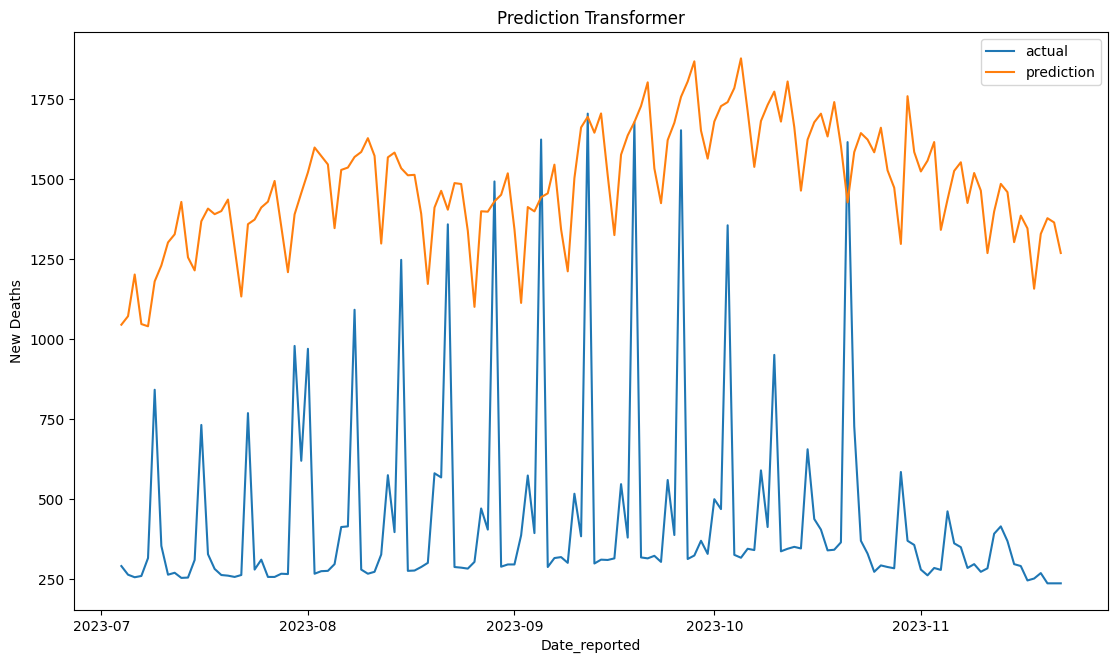

In [ ]:
plot(0)